In [1]:
import pingouin as pg
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

Load data for validation of IAS's predictive power.

In [2]:
# Load stats test results for IAS models against baselines includind surprisal, Aligned corpus
exp1_ias_devarda = pd.read_csv("results/aligned_ols_against_surprisal.csv")

# Exclude variables that are not of interest
exp1_ias_devarda = exp1_ias_devarda[
    (~ exp1_ias_devarda.y.isin(['rating_s', 'cloze_s', 'competition']))
]

# Load stats test results for IAS models against baselines includind surprisal, Natural Stories corpus
exp1_ias_natst = pd.read_csv("results/naturalstories_ols_against_surprisal.csv")

# Merge results for the two corpora
exp1_ias_devarda['corpus'] = 'Aligned'
exp1_ias_natst['corpus'] = 'Natural Stories'
exp1_ias = pd.concat([exp1_ias_devarda, exp1_ias_natst])

# Split full corpus vs. 10-fold results
exp1_ias_full = exp1_ias[(exp1_ias.fold == 'full')]
exp1_ias_folds = exp1_ias[(exp1_ias.fold != 'full')]


Load data for head to head comparison between surprisal and IAS.

In [3]:
# Load stats test results for target OLS models against control baselines, Aligned corpus
exp1_h2h_devarda = pd.read_csv("results/aligned_ols_against_baseline.csv")

# Exclude variables that are not of interest
exp1_h2h_devarda = exp1_h2h_devarda[
    (~ exp1_h2h_devarda.y.isin(['rating_s', 'cloze_s', 'competition']))
]

# Load stats test results for target OLS models against control baselines, Natural Stories corpus
exp1_h2h_natst = pd.read_csv("results/naturalstories_ols_against_baseline.csv")

# Merge results for the two corpora
exp1_h2h_devarda['corpus'] = 'Aligned'
exp1_h2h_natst['corpus'] = 'Natural Stories'
exp1_h2h = pd.concat([exp1_h2h_devarda, exp1_h2h_natst])

# Split full corpus vs. 10-fold results
exp1_h2h_full = exp1_h2h[(exp1_h2h.fold == 'full')]
exp1_h2h_folds = exp1_h2h[(exp1_h2h.fold != 'full')]


Normalize layer depths and rename aggregation functions for visualisation

In [4]:
rename_model_dict = {
    'gpt2_small': 'GPT-2 Small',
    'gpt2_medium': 'GPT-2 Medium',
    'gpt2_large': 'GPT-2 Large',
    'gpt2_xl': 'GPT-2 XL'
}
rename_aggregation_dict = {
    'mean': r'$d_{mean}$',
    'max': r'$d_{max}$',
    'min': r'$d_{min}$'
}

for df in [exp1_ias, exp1_h2h, exp1_ias_full, exp1_ias_folds, exp1_h2h_full, exp1_h2h_folds]:
    df['aggregation_name'] = df['aggregation'].map(rename_aggregation_dict)
    df['model'] = df['model'].map(rename_model_dict)
    # df['y'] = df['y'].map(y_labels)
    
    layer_depth = []
    for _, row in df.iterrows():
        if row.metric == 'Surprisal' or row.layer == 'All':
            layer_depth.append(None)
            continue
            
        if row.model == 'GPT-2 Small':
            layer_depth.append(str(int(round(100 * int(row.layer) / 12))))
        elif row.model == 'GPT-2 Medium':
            layer_depth.append(str(int(round(100 * int(row.layer) / 24))))
        elif row.model == 'GPT-2 Large':
            layer_depth.append(str(int(round(100 * int(row.layer) / 36))))
        elif row.model == 'GPT-2 XL':
            layer_depth.append(str(int(round(100 * int(row.layer) / 48))))
        else:
            layer_depth.append(None)
    
    df['layer_depth'] = layer_depth


/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/579453817.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aggregation_name'] = df['aggregation'].map(rename_aggregation_dict)
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/579453817.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].map(rename_model_dict)
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/579453817.py:35: SettingWithCopyWarning: 
A value is trying to be set 

Define and rename predicted variables for visualisation

In [5]:
y_labels = {
    'cloze_p_smoothed': 'Cloze probability',
    # 'entropy': 'Cloze entropy',
    'rating_mean': 'Predictability',
    # 'rating_sd': 'Predictability SD',
    'RTfirstfix': 'First fixation RT',
    'RTfirstpass': 'First pass RT',
    'RTrightbound': 'Right-bounded RT',
    'RTgopast': 'Go-past RT',
    'self_paced_reading_time': 'Self-paced RT',
    'ELAN': 'ELAN',
    'LAN': 'LAN',
    'PNP': 'PNP',
    'EPNP': 'EPNP',
    'P600': 'P600',
    'N400': 'N400',
    'meanItemRT': 'Self-paced RT\n(Natural Stories)',
    # 'sdItemRT': 'Self-paced RT SD\n(Natural Stories)',
}

### Hypothesis 1

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/2972129474.py:21: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/2972129474.py:21: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/2972129474.py:21: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760

<Figure size 1600x1000 with 0 Axes>

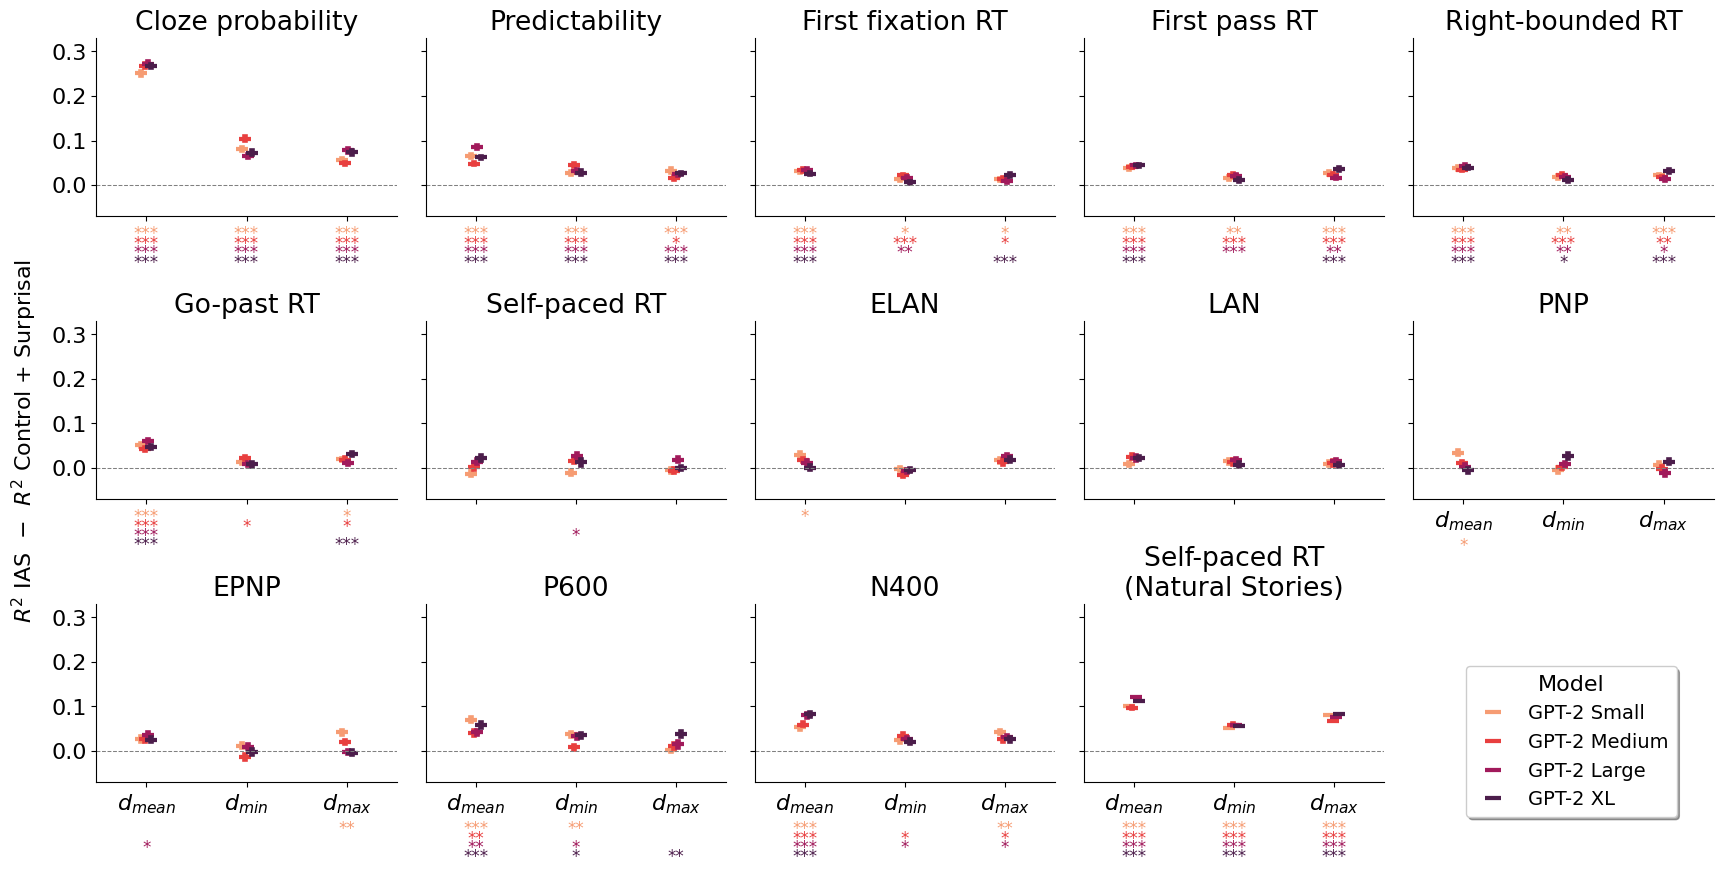

In [6]:
matplotlib.rcParams.update({'font.size': 16})

# beautiful palette when used with four colors
_palette = sns.color_palette("rocket_r", 4)

df = exp1_ias[
    ~ exp1_ias.y.isin(['sdItemRT', 'entropy', 'rating_sd'])
]

plt.figure(figsize=(16, 10))

g = sns.FacetGrid(df, col='y', col_wrap=5, height=3, sharey=True, sharex=True, col_order=y_labels.keys())

def plot_subplot(data, **kwargs):
    data_folds = data[
        (data.fold != 'full') &
        (data.horizon == 'All') & 
        (data.layer == 'All')
    ]
    
    sns.pointplot(
        x='aggregation_name', y='delta_rsquared_adj', hue='model', data=data_folds,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )
    plt.ylim(-0.07, 0.33)

    # add dashed thin horizontal line at 0
    plt.axhline(0, ls='--', color='gray', lw=0.75)

    # y-ticks every 0.1
    plt.yticks(np.arange(0, 0.40, 0.1))
    
    # Annotated significance
    for i, model in enumerate(data_folds.model.unique()):
        for j, agg_func in enumerate(data_folds.aggregation.unique()):
            p = data[
                (data.fold == 'full') &
                (data.horizon == 'All') & 
                (data.layer == 'All') *
                (data.model == model) &
                (data.aggregation == agg_func)
            ].anova_p.item()
            if p < 0.0001:
                significance_label = '***'
            elif p < 0.001:
                significance_label = '**'
            elif p < 0.01:
                significance_label = '*'
            else:
                significance_label = ''
            
            col = data.y.unique()[0]
            if col in ['N400', 'P600', 'PNP', 'EPNP', 'meanItemRT']:
                plt.text(j, -0.175 - i * 0.021, significance_label, ha='center', va='center', color=_palette[i], fontsize=12)
            else:
                plt.text(j, -0.11 - i * 0.021, significance_label, ha='center', va='center', color=_palette[i], fontsize=12)

            
# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
# legend with box 
g.add_legend(title='Model', bbox_to_anchor=(0.97, 0.16), title_fontsize=16, fontsize=14, markerscale=1.5, frameon=True, fancybox=True, shadow=True)


for ax, y in zip(g.axes.flat, y_labels.values()):
    ax.set_title(y)
    
# g.fig.text(0.465, -0.03, s='Distance statistic',fontdict={'fontsize': 16}) 
g.fig.text(-0.01, 0.30, s='$R^2$ IAS  $-$  $R^2$ Control + Surprisal', rotation=90, fontdict={'fontsize':16})

# Save figure
plt.tight_layout()
plt.savefig('figures/ias_summ_stat_against_surprisal_baseline.eps', bbox_inches='tight')

# Show plot
plt.show()


### Hypothesis 2

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/1931385563.py:19: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/1931385563.py:19: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/1931385563.py:19: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760

<Figure size 1600x1000 with 0 Axes>

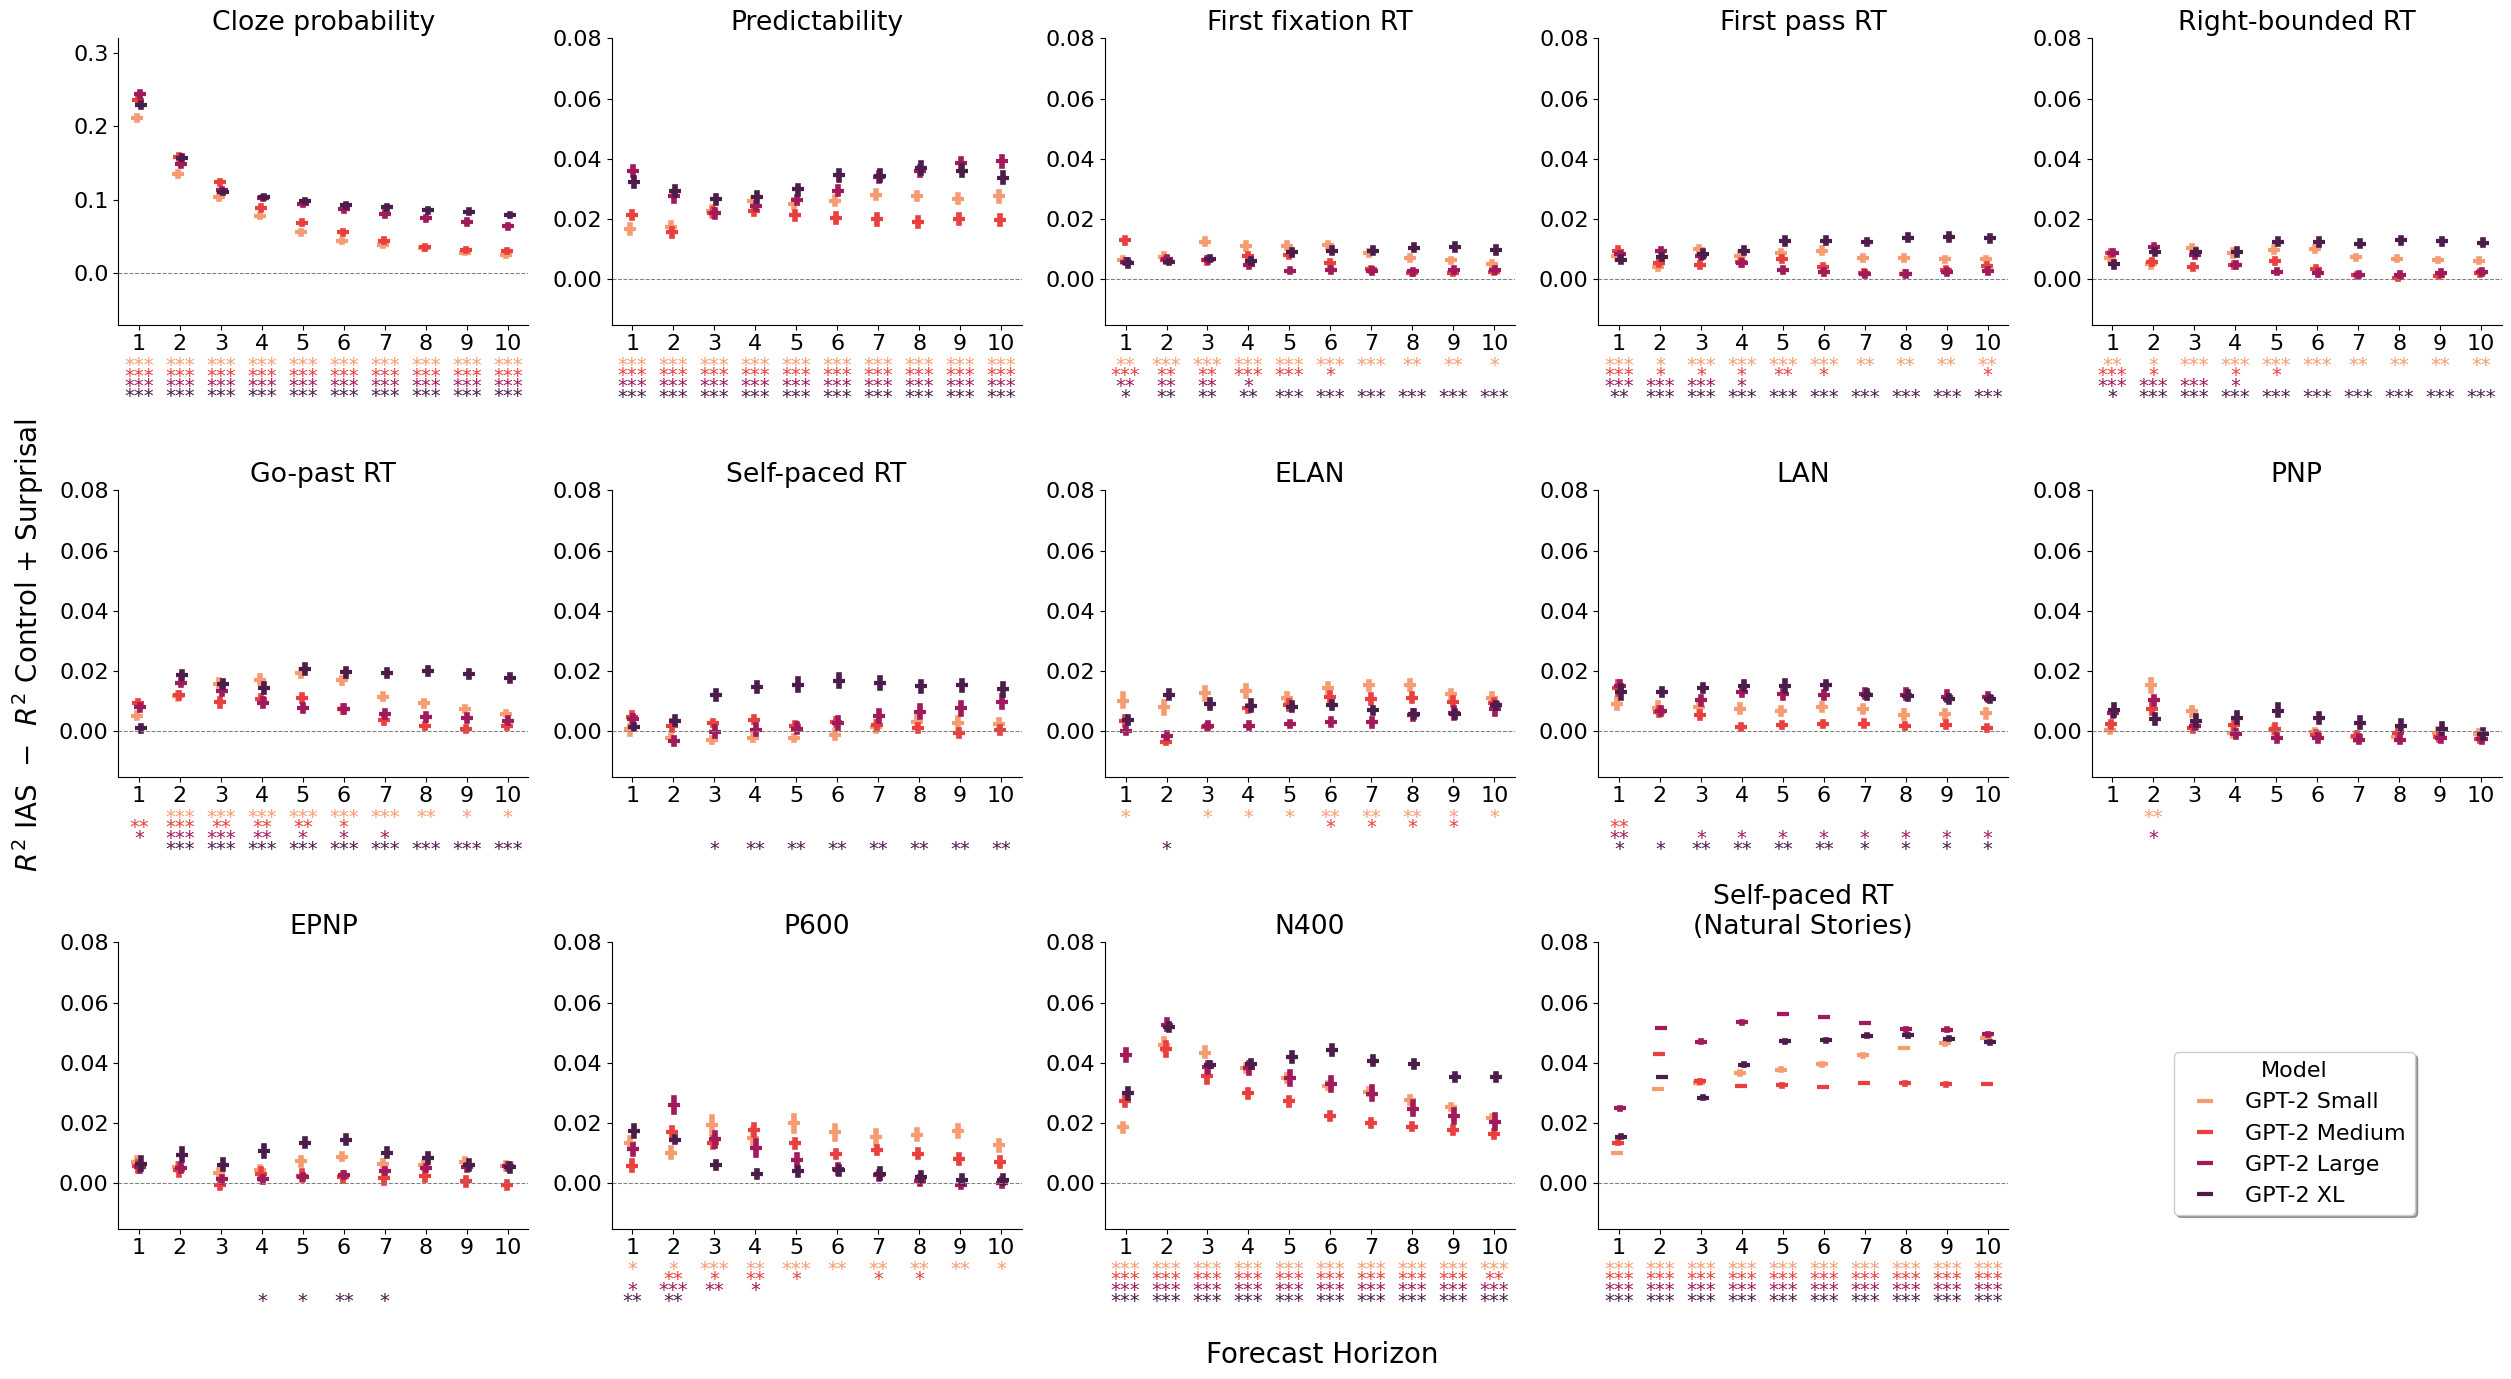

In [7]:
matplotlib.rcParams.update({'font.size': 16})

df = exp1_ias[
    ~ exp1_ias.y.isin(['sdItemRT', 'entropy', 'rating_sd'])
]

plt.figure(figsize=(16, 10))

g = sns.FacetGrid(df, col='y', col_wrap=5, height=4.5, sharey=False, sharex=False, col_order=y_labels.keys())

def plot_subplot(data, **kwargs):
    data_folds = data[
        (data.fold != 'full') &
        (data.horizon != 'All') &
        (data.layer == 'All') & 
        (data.aggregation == 'mean')
    ]
    
    sns.pointplot(
        x='horizon', y='delta_rsquared_adj', hue='model', data=data_folds,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )
    col = data.y.unique()[0]
    if col == 'cloze_p_smoothed':
        plt.ylim(-0.07, 0.32)
    else:
        plt.ylim(-0.015, 0.08)
    
    # add dashed thin horizontal line at 0
    plt.axhline(0, ls='--', color='gray', lw=0.75)
    
    # Annotated significance
    for i, model in enumerate(data_folds.model.unique()):
        for j, horizon in enumerate(data_folds.horizon.unique()):
            p = data[
                (data.fold == 'full') &
                (data.layer == 'All') &
                (data.aggregation == 'mean') &
                (data.model == model) &
                (data.horizon == horizon)
            ].anova_p.item()
            
            if p < 0.0001:
                significance_label = '***'
            elif p < 0.001:
                significance_label = '**'
            elif p < 0.01:
                significance_label = '*'
            else:
                significance_label = ''
            
            if col == 'cloze_p_smoothed':
                plt.text(j, -0.126 - i * 0.014, significance_label, ha='center', va='center', color=_palette[i], fontsize=14)
            else:
                plt.text(j, -0.0285 - i * 0.0035, significance_label, ha='center', va='center', color=_palette[i], fontsize=14)

                
# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
g.add_legend(title='Model', bbox_to_anchor=(0.96, 0.15), title_fontsize=16, fontsize=16, markerscale=1.5, frameon=True, fancybox=True, shadow=True)

for ax, y in zip(g.axes.flat, y_labels.values()):
    ax.set_title(y)
    
g.fig.text(0.47, -0.02, s='Forecast Horizon',fontdict={'fontsize':20})
g.fig.text(-0.01, 0.35, s='$R^2$ IAS  $-$  $R^2$ Control + Surprisal',fontdict={'fontsize':20}, rotation=90)

# Save plot
plt.tight_layout()
plt.savefig('figures/ias_horizon_against_surprisal_baseline.eps', bbox_inches='tight')

# Show
plt.show()


### Hypothesis 3

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/99444946.py:27: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/99444946.py:27: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/99444946.py:27: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/99444

<Figure size 1600x1000 with 0 Axes>

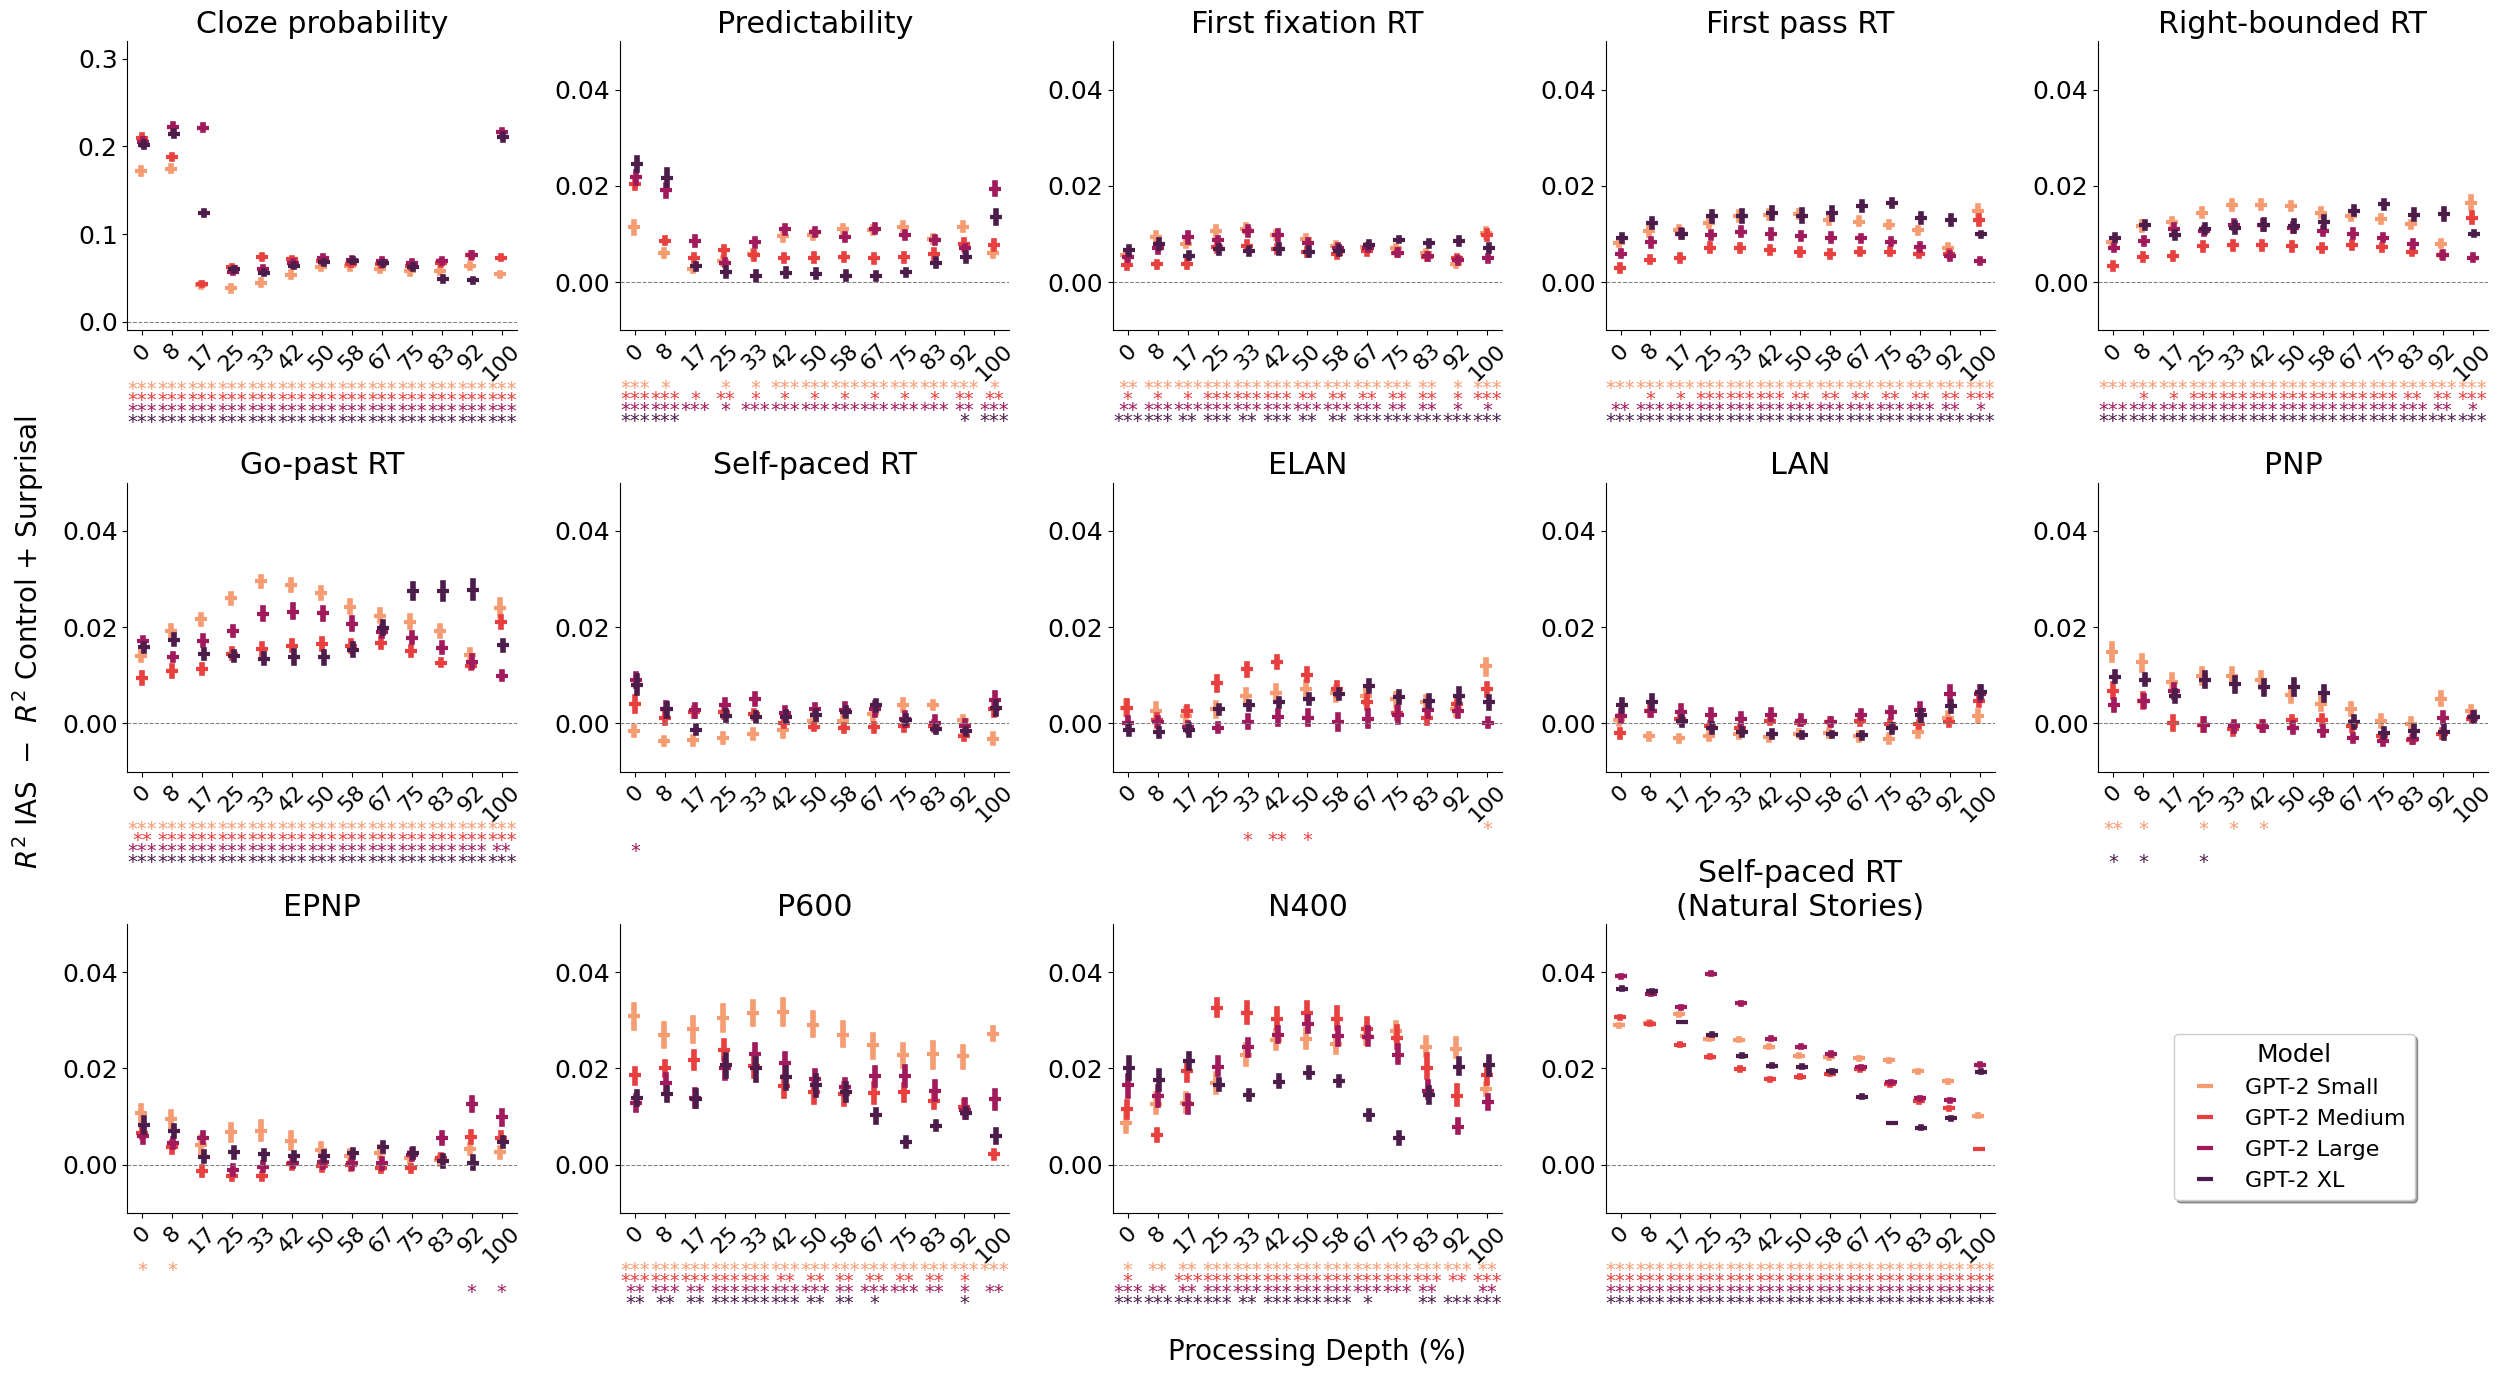

In [8]:
LAYERS = {
    "GPT-2 Small": list(range(0, 13)),
    "GPT-2 Medium": list(range(0, 25, 2)),
    "GPT-2 Large": list(range(0, 37, 3)),
    "GPT-2 XL": list(range(0, 49, 4))
}


matplotlib.rcParams.update({'font.size': 18})

df = exp1_ias[
    ~ exp1_ias.y.isin(['sdItemRT', 'entropy', 'rating_sd'])
]

plt.figure(figsize=(16, 10))

g = sns.FacetGrid(df, col='y', col_wrap=5, height=4.5, sharey=False, sharex=False, col_order=y_labels.keys())

def plot_subplot(data, **kwargs):
    data_folds = data[
        (data.fold != 'full') &
        (data.horizon == 'All') &
        (data.layer != 'All') & 
        (data.aggregation == 'mean')
    ]
    
    sns.pointplot(
        x='layer_depth', y='delta_rsquared_adj', hue='model', data=data_folds,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )
    col = data.y.unique()[0]
    if col == 'cloze_p_smoothed':
        plt.ylim(-0.01, 0.32)
    else:
        plt.ylim(-0.01, 0.05)
        
    plt.xticks(rotation=45, ha='center', fontsize=16)

    # add dashed thin horizontal line at 0
    plt.axhline(0, ls='--', color='gray', lw=0.75)
    
    # Annotated significance
    for i, model in enumerate(data_folds.model.unique()):
        for j, layer in enumerate(LAYERS[model]):
            p = data[
                (data.fold == 'full') &
                (data.horizon == 'All') &
                (data.aggregation == 'mean') &
                (data.model == model) &
                (data.layer == str(layer))
            ].anova_p.item()
            
            if p < 0.0001:
                significance_label = '***'
            elif p < 0.001:
                significance_label = '**'
            elif p < 0.01:
                significance_label = '*'
            else:
                significance_label = ''
            
            if col == 'cloze_p_smoothed':
                plt.text(j, -0.078 - i * 0.0123, significance_label, ha='center', va='center', color=_palette[i], fontsize=14)
            else:
                plt.text(j, -0.022 - i * 0.0023, significance_label, ha='center', va='center', color=_palette[i], fontsize=14)
            
# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
g.add_legend(title='Model', bbox_to_anchor=(0.96, 0.16), title_fontsize=16, fontsize=16, markerscale=1.5, frameon=True, fancybox=True, shadow=True)

for ax, y in zip(g.axes.flat, y_labels.values()):
    ax.set_title(y)
    
g.fig.text(0.455, -0.02, s='Processing Depth (%)',fontdict={'fontsize':20})
g.fig.text(-0.01, 0.35, s='$R^2$ IAS  $-$  $R^2$ Control + Surprisal',fontdict={'fontsize':20}, rotation=90)

# Save plot
plt.tight_layout()
plt.savefig('figures/ias_layer_against_surprisal_baseline.eps', bbox_inches='tight')

# Show plot
plt.show()


### Hypothesis 4

Focus on Cloze probability, predictability, RTs, N400, and P600. 

In [9]:
y_labels_focussed = {
    'cloze_p_smoothed': 'Cloze probability',
    'rating_mean': 'Predictability',
    'RTfirstfix': 'First fixation RT',
    'RTfirstpass': 'First pass RT',
    'RTrightbound': 'Right-bounded RT',
    'RTgopast': 'Go-past RT',
    'P600': 'P600',
    'N400': 'N400',
    'meanItemRT': 'Self-paced RT\n(Natural Stories)'
}

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

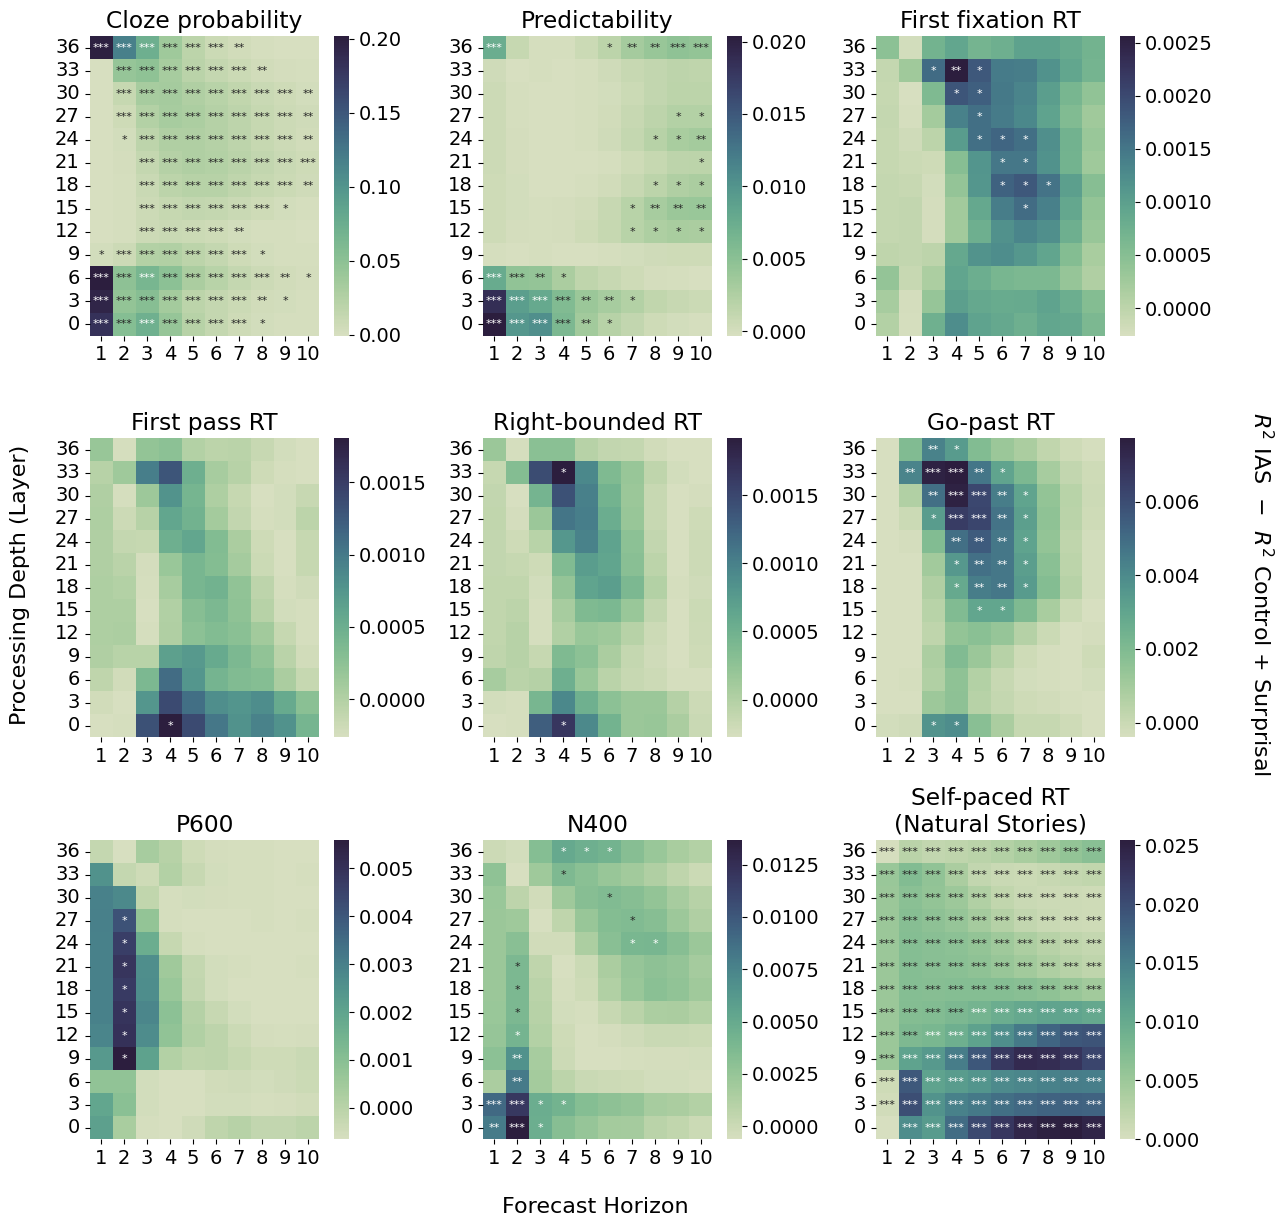

In [10]:
matplotlib.rcParams.update({'font.size': 14})

df = exp1_ias[
    exp1_ias.y.isin(y_labels_focussed.keys())
]

for model_size in ['Small', 'Medium', 'XL', 'Large']:
    plt.figure(figsize=(16, 10))

    g = sns.FacetGrid(df, col='y', col_wrap=3, height=4, sharey=False, sharex=False, col_order=y_labels_focussed.keys())

    def plot_subplot(data, **kwargs):
        data_full = data[
            (data.fold == 'full') &
            (data.horizon != 'All') &
            (data.layer != 'All') & 
            (data.aggregation == 'mean') &
            (data.model == f'GPT-2 {model_size}')
        ]
        # display(data_full)
        matrix = np.zeros((len(data_full.layer.unique()), len(data_full.horizon.unique())))
        labels_matrix = np.zeros_like(matrix).tolist()
        for j, layer in enumerate(data_full.layer.unique()[::-1]):
            
            for k, horizon in enumerate(data_full.horizon.unique()):
                # print(layer, horizon)
                tmp_df = data_full[
                    (data_full.layer == layer) &
                    (data_full.horizon == horizon)
                ]

                matrix[j, k] = tmp_df["delta_rsquared_adj"].item()
                pval = float(tmp_df["anova_p"].item())
                if pval < 0.0001:
                    label = "***"
                elif pval < 0.001:
                    label = "**"
                elif pval < 0.01:
                    label = "*"
                else:
                    label = ""
                labels_matrix[j][k] = label
        sns.heatmap(
            matrix, 
            ax=plt.gca(), 
            cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
            vmin=data_full["delta_rsquared_adj"].min(),
            vmax=data_full["delta_rsquared_adj"].max(),
            annot = labels_matrix,
            annot_kws={"size": 8},
            fmt="s",
            xticklabels=data_full.horizon.unique(),
            yticklabels=data_full.layer.unique()[::-1]
        )
        
    # Map the function to each subplot
    g.map_dataframe(plot_subplot)

    # Adjust labels and legend
    g.set_axis_labels('', '')

    for ax, y in zip(g.axes.flat, y_labels_focussed.values()):
        ax.set_title(y)
        
    g.fig.text(0.39, -0.02, s='Forecast Horizon',fontdict={'fontsize':16})
    g.fig.text(-0.02, 0.39, s='Processing Depth (Layer)',fontdict={'fontsize':16}, rotation=90)
    g.fig.text(1.01, 0.35, s='$R^2$ IAS  $-$  $R^2$ Control + Surprisal',fontdict={'fontsize':16}, rotation=270)


    # Save plot
    plt.tight_layout()
    plt.savefig(f'figures/ias_horizon_layer_against_surprisal_baseline_gpt2{model_size.lower()}.eps', bbox_inches='tight')
    
    if model_size == 'Large':
        plt.show()
    else:
        plt.close()


### Inter-subject variability

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/3976826841.py:26: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/3976826841.py:26: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/3976826841.py:26: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
The PostScript backend does not support transparency; partially 

<Figure size 1600x1000 with 0 Axes>

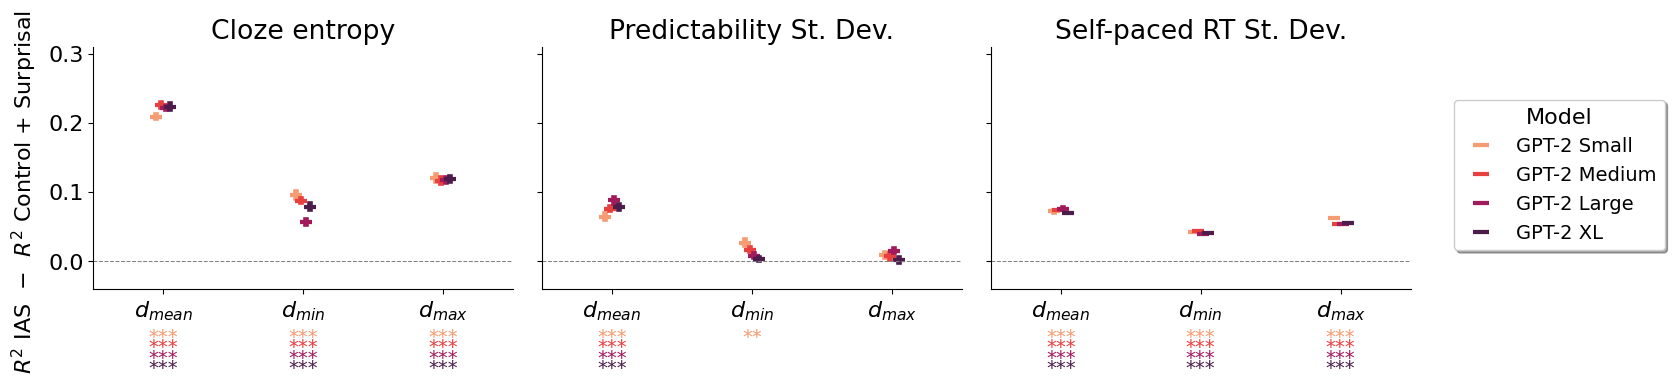

In [11]:
y_labels_variability = {
    'entropy': 'Cloze entropy',
    'rating_sd': 'Predictability St. Dev.',
    'sdItemRT': 'Self-paced RT St. Dev.',
}

matplotlib.rcParams.update({'font.size': 16})
_palette = sns.color_palette("rocket_r", 4)

df = exp1_ias[
    exp1_ias.y.isin(['entropy', 'rating_sd', 'sdItemRT']) 
]

plt.figure(figsize=(16, 10))

g = sns.FacetGrid(df, col='y', col_wrap=3, height=4, sharey=True, sharex=False, col_order=y_labels_variability.keys())

def plot_subplot(data, **kwargs):
    data_folds_ias = data[
        (data.fold != 'full') &
        (data.metric == 'Information value') &
        (data.layer == 'All') &
        (data.horizon == 'All')
    ]
    
    sns.pointplot(
        x='aggregation_name', y='delta_rsquared_adj', hue='model', data=data_folds_ias,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )
    plt.ylim(-0.04, 0.31)
    plt.xticks(rotation=0, ha='center')
    
    # add dashed thin horizontal line at 0
    plt.axhline(0, ls='--', color='gray', lw=0.75)
    
    # Annotated significance
    for i, model in enumerate(data_folds_ias.model.unique()):
        for j, agg_func in enumerate(data_folds_ias.aggregation.unique()):
            p = data[
                (data.fold == 'full') &
                (data.horizon == 'All') & 
                (data.layer == 'All') *
                (data.model == model) &
                (data.aggregation == agg_func)
            ].anova_p.item()
            if p < 0.0001:
                significance_label = '***'
            elif p < 0.001:
                significance_label = '**'
            elif p < 0.01:
                significance_label = '*'
            else:
                significance_label = ''

            plt.text(j, -0.11 - i * 0.015, significance_label, ha='center', va='center', color=_palette[i], fontsize=14)
            

                
# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
g.add_legend(title='Model', bbox_to_anchor=(1.17, 0.55), title_fontsize=16, fontsize=14, markerscale=1.5, frameon=True, fancybox=True, shadow=True)


for ax, y in zip(g.axes.flat, y_labels_variability.values()):
    ax.set_title(y)
    
# g.fig.text(0.395, -0.02, s='Distance statistic',fontdict={'fontsize':16}) 
g.fig.text(-0.01, 0.07, s='$R^2$ IAS  $-$  $R^2$ Control + Surprisal',fontdict={'fontsize':16}, rotation=90)

# Save plot
plt.tight_layout()
plt.savefig('figures/ias_variability_against_surprisal.eps', bbox_inches='tight')

plt.show()


### Partial correlation surprisal - incremental information value

In [12]:
estimates_devarda = pd.read_csv("preprocessed_corpora/aligned_preprocessed_normalised.csv")
estimates_natst = pd.read_csv("preprocessed_corpora/naturalstories_preprocessed_normalised.csv")
estimates_natst = estimates_natst.rename(columns={'zone': 'context_length'})
estimates = pd.concat([estimates_devarda, estimates_natst])


/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/3985476876.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  matrix_mean[j, k] = pg.partial_corr(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/3985476876.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  matrix_min[j, k] = pg.partial_corr(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/3985476876.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  matrix_mean[j, k] = pg.partial_corr(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/3985476876.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(s

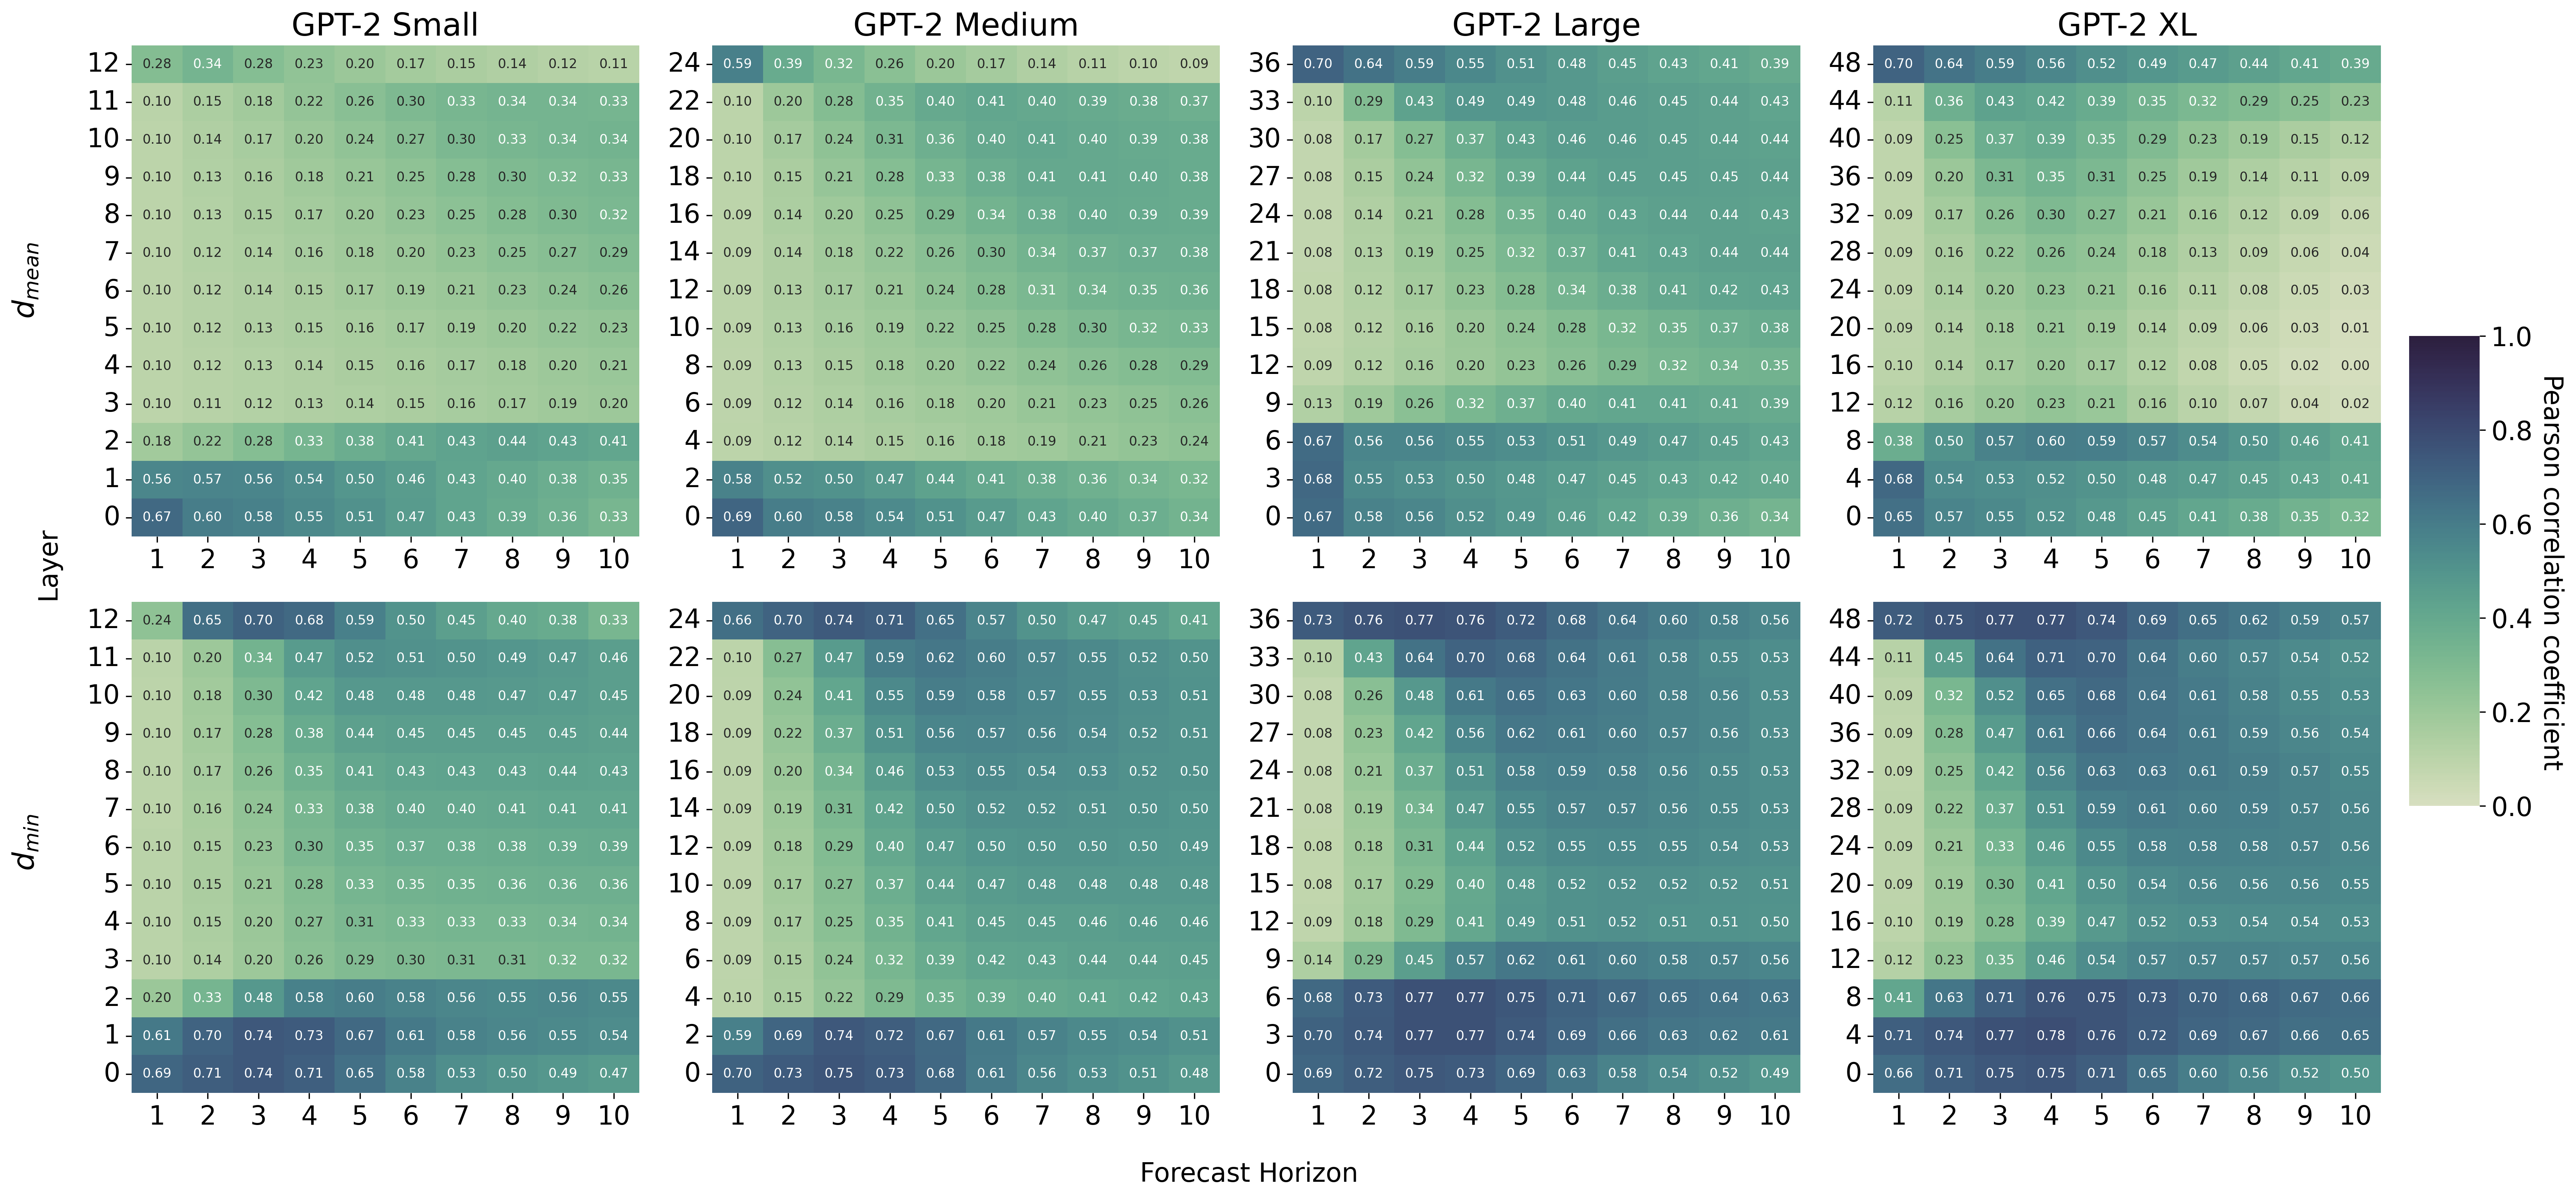

In [13]:
MODEL_NAMES = ['gpt2-small', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
FORECAST_HORIZONS = list(range(1, 11))
_LAYERS = {
    "gpt2-small": list(range(0, 13)),
    "gpt2-medium": list(range(0, 25, 2)),
    "gpt2-large": list(range(0, 37, 3)),
    "gpt2-xl": list(range(0, 49, 4))
}
model_name_labels = {
    "gpt2-small": "GPT-2 Small",
    "gpt2-medium": "GPT-2 Medium",
    "gpt2-large": "GPT-2 Large",
    "gpt2-xl": "GPT-2 XL"
}

matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(2, 4, figsize=(20, 10), dpi=300)
cbar_ax = fig.add_axes([1, .3, .03, .4])


for i, model in enumerate(MODEL_NAMES):
    matrix_mean = np.zeros((len(_LAYERS[model]), len(FORECAST_HORIZONS)))
    matrix_min = np.zeros((len(_LAYERS[model]), len(FORECAST_HORIZONS)))
    
    for j, layer in enumerate(_LAYERS[model][::-1]):
        for k, horizon in enumerate(FORECAST_HORIZONS):
            
            col_mean = f'{model}_iv_1_H{horizon}_L{layer}_Smean'
            col_min = f'{model}_iv_1_H{horizon}_L{layer}_Smin'
            
            matrix_mean[j, k] = pg.partial_corr(
                data=estimates, 
                x=f'{model}_surprisal', 
                y=col_mean, 
                covar=['length', 'context_length', 'Subtlex_log10']
            ).round(3)['r']
            
            matrix_min[j, k] = pg.partial_corr(
                data=estimates, 
                x=f'{model}_surprisal', 
                y=col_min, 
                covar=['length', 'context_length', 'Subtlex_log10']
            ).round(3)['r']

    sns.heatmap(
        matrix_mean, 
        annot=True, 
        ax=ax[0, i],
        cbar=i==0,
        cbar_ax=None if i else cbar_ax,
        cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
        vmin=0, vmax=1,
        fmt=".2f",
        annot_kws={"fontsize":8}
    )
    
    ax[0, i].set_title(model_name_labels[model])
    ax[0, i].set_yticklabels(_LAYERS[model][::-1])
    ax[0, i].set_xticklabels(FORECAST_HORIZONS)
    
    sns.heatmap(
        matrix_min, 
        annot=True, 
        ax=ax[1, i], 
        cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
        vmin=0, vmax=1,
        cbar=False,
        fmt=".2f",
        annot_kws={"fontsize":8}
    )
    
    ax[1, i].set_yticklabels(_LAYERS[model][::-1])
    ax[1, i].set_xticklabels(FORECAST_HORIZONS)
    
fig.text(0.46, -0.02, s='Forecast Horizon',fontdict={'fontsize':16})
fig.text(-0.01, 0.48, s='Layer',fontdict={'fontsize':16}, rotation=90)
fig.text(-0.02, 0.25, s='$d_{min}$',fontdict={'fontsize':18, 'weight':'bold'}, rotation=90)
fig.text(-0.02, 0.72, s='$d_{mean}$',fontdict={'fontsize':18, 'weight':'bold'}, rotation=90)
fig.text(1.055, 0.335, s='Pearson correlation coefficient',fontdict={'fontsize':16}, rotation=270)


plt.subplots_adjust(
    wspace = 0.3,
    hspace = 0.3
)
plt.tight_layout()

# plt.suptitle('Partial Correlation between Surprisal and Information Value (Mean)', fontsize=6
plt.savefig('figures/partial_corr_ias_surprisal_min_mean.eps', bbox_inches='tight')

plt.show()


### Head-to-head comparison: surprisal vs. incremental information value

Collect results for comparison.

In [14]:
from math import isclose

rsquared_adj_comparison = []

fold_str_list = list(map(str, range(10))) + ['full']

for y in tqdm(exp1_h2h.y.unique()):
    for corpus in exp1_h2h.corpus.unique():
        for model in exp1_h2h.model.unique():
            for fold in fold_str_list:
                
                # Find relevant rows
                surprisal_row = exp1_h2h[
                    (exp1_h2h.y == y) &
                    (exp1_h2h.corpus == corpus) &
                    (exp1_h2h.model == model) &
                    (exp1_h2h.fold == fold) &
                    (exp1_h2h.metric == 'Surprisal')
                ]
                ias_row = exp1_h2h[
                    (exp1_h2h.y == y) &
                    (exp1_h2h.corpus == corpus) &
                    (exp1_h2h.model == model) &
                    (exp1_h2h.fold == fold) &
                    (exp1_h2h.metric == 'Information value') &
                    (exp1_h2h.layer == 'All') &
                    (exp1_h2h.horizon == 'All') 
                ]
                ias_over_surprisal_row = exp1_ias[
                    (exp1_ias.y == y) &
                    (exp1_ias.corpus == corpus) &
                    (exp1_ias.model == model) &
                    (exp1_ias.fold == fold) &
                    (exp1_ias.metric == 'Information value') &
                    (exp1_ias.layer == 'All') &
                    (exp1_ias.horizon == 'All') 
                ]
                
                # If y not in corpus, skip
                if len(surprisal_row) == len(ias_row) == len(ias_over_surprisal_row) == 0:
                    continue
                    
                assert(len(surprisal_row) == 1)
                assert(len(ias_row) == 3)
                assert(len(ias_over_surprisal_row) == 3)
                
                # Get adjusted rsquared values per linear model
                
                # Baseline + Surprisal
                surprisal_rsquared_adj = surprisal_row.rsquared_adj.item()
                
                # Baseline + IAS
                ias_mean_rsquared_adj = ias_row[ias_row.aggregation == "mean"].rsquared_adj.item()
                ias_min_rsquared_adj = ias_row[ias_row.aggregation == "min"].rsquared_adj.item()
                
                # Baseline + Surprisal + IAS
                surprisal_ias_mean_rsquared_adj = ias_over_surprisal_row[
                    ias_over_surprisal_row.aggregation == "mean"].rsquared_adj.item()
                surprisal_ias_min_rsquared_adj = ias_over_surprisal_row[
                    ias_over_surprisal_row.aggregation == "min"].rsquared_adj.item()
                
                # Baseline    
                baseline_rsquared_adj = surprisal_rsquared_adj - surprisal_row.delta_rsquared_adj.item()
                
                # double checking that baseline rsquared is the same when estimated with surprisal and IAS models
                assert(isclose(
                    baseline_rsquared_adj, 
                    ias_mean_rsquared_adj - ias_row[ias_row.aggregation == "mean"].delta_rsquared_adj.item(), 
                    abs_tol=1e-8
                ))
                
                
                # Store values in a new dataframe
                rsquared_adj_comparison.append({
                    "y": y,
                    "model": model,
                    "corpus": corpus,
                    "fold": fold,
                    "linear_model": "Baseline",
                    "score": baseline_rsquared_adj
                })
                rsquared_adj_comparison.append({
                    "y": y,
                    "model": model,
                    "corpus": corpus,
                    "fold": fold,
                    "linear_model": "Suprisal",
                    "score": surprisal_rsquared_adj
                })
                rsquared_adj_comparison.append({
                    "y": y,
                    "model": model,
                    "corpus": corpus,
                    "fold": fold,
                    "linear_model": "IAS Mean",
                    "score": ias_mean_rsquared_adj,
                })
                rsquared_adj_comparison.append({
                    "y": y,
                    "model": model,
                    "corpus": corpus,
                    "fold": fold,
                    "linear_model": "Surprisal + IAS Mean",
                    "score": surprisal_ias_mean_rsquared_adj,
                })
                rsquared_adj_comparison.append({
                    "y": y,
                    "model": model,
                    "corpus": corpus,
                    "fold": fold,
                    "linear_model": "IAS Min",
                    "score": ias_min_rsquared_adj,
                })
                rsquared_adj_comparison.append({
                    "y": y,
                    "model": model,
                    "corpus": corpus,
                    "fold": fold,
                    "linear_model": "Surprisal + IAS Min",
                    "score": surprisal_ias_min_rsquared_adj,
                })
                
rsquared_adj_comparison_df = pd.DataFrame(rsquared_adj_comparison)


  0%|          | 0/17 [00:00<?, ?it/s]

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/3270573407.py:15: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/3270573407.py:15: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760/3270573407.py:15: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_21760

<Figure size 1600x1000 with 0 Axes>

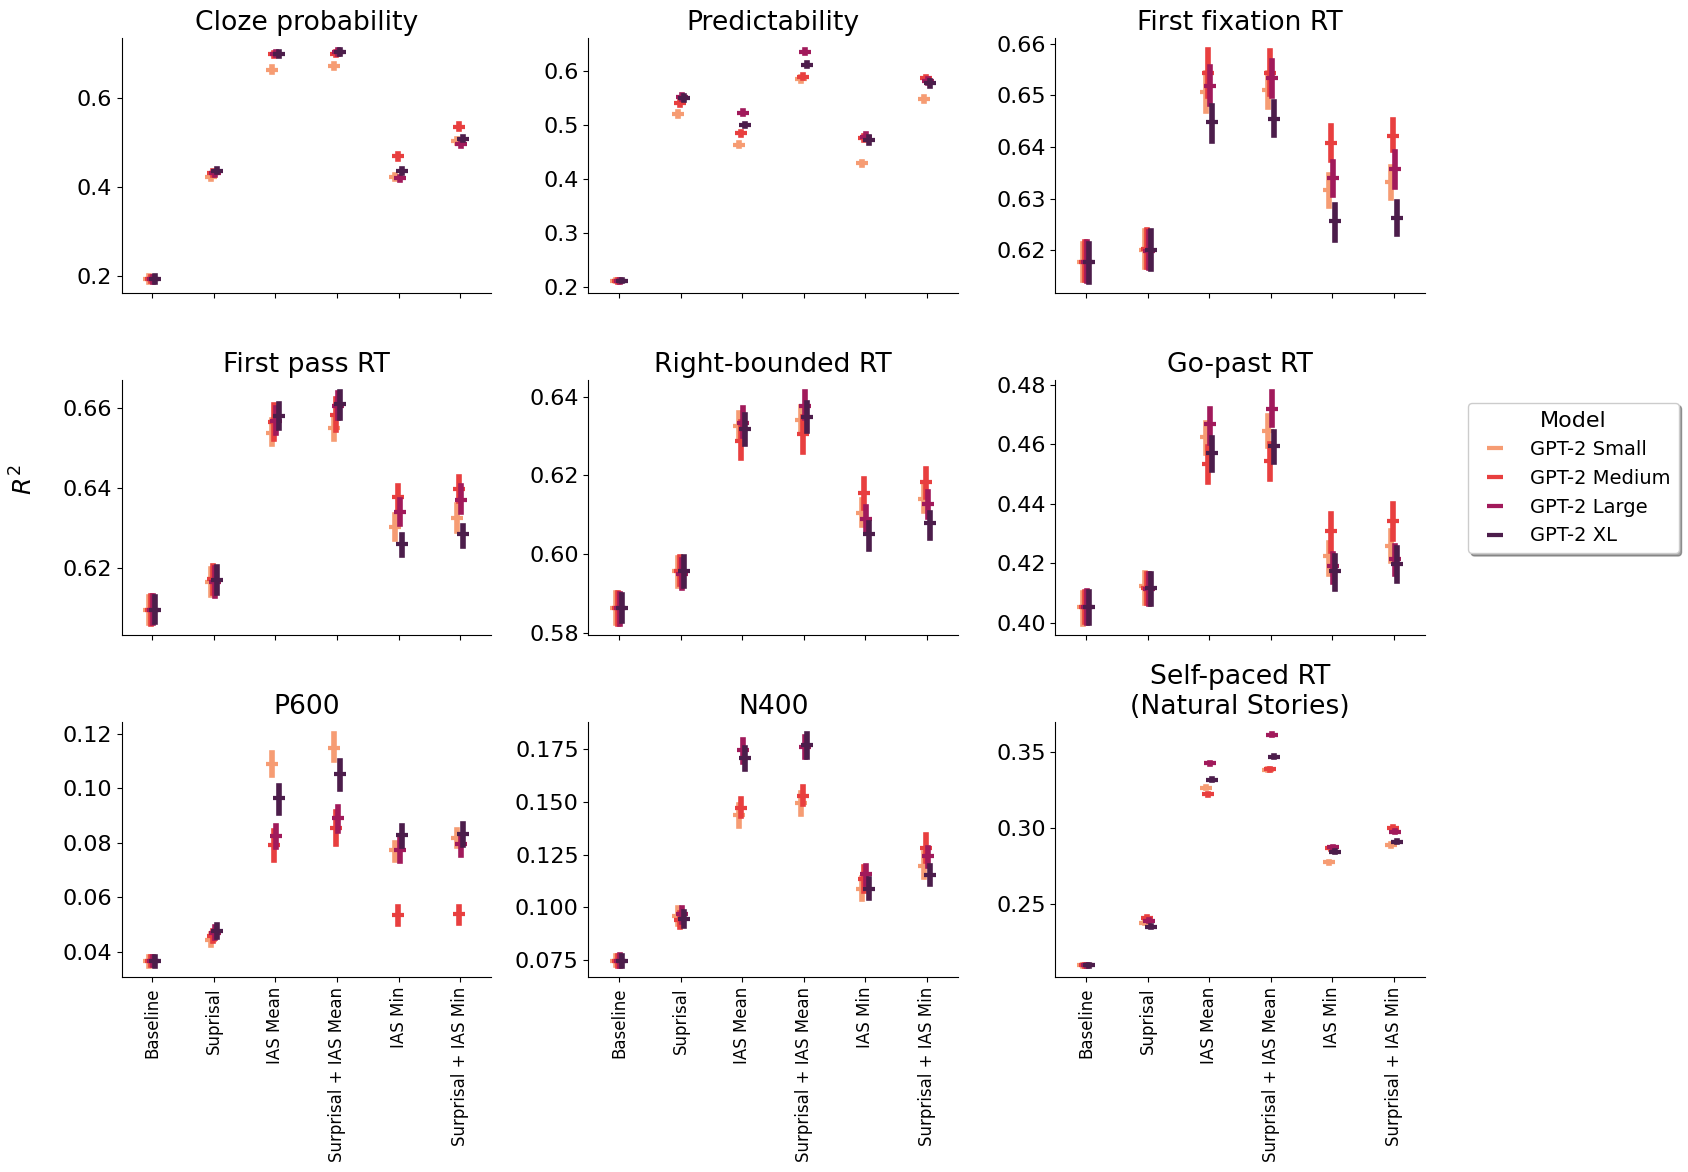

In [15]:
matplotlib.rcParams.update({'font.size': 16})
_palette = sns.color_palette("rocket_r", 4)

df = rsquared_adj_comparison_df[
    rsquared_adj_comparison_df.y.isin(y_labels_focussed.keys())
]

plt.figure(figsize=(16, 10))

g = sns.FacetGrid(df, col='y', col_wrap=3, height=4, sharey=False, sharex=True, col_order=y_labels_focussed.keys())

def plot_subplot(data, **kwargs):
    

    sns.pointplot(
        x='linear_model', y='score', hue='model', data=data,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )

    plt.xticks(rotation=90, ha='center', fontsize=12)

# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
g.add_legend(title='Model', bbox_to_anchor=(1.17, 0.59), title_fontsize=16, fontsize=14, markerscale=1.5, frameon=True, fancybox=True, shadow=True)


for ax, y in zip(g.axes.flat, y_labels_focussed.values()):
    ax.set_title(y)
    
# g.fig.text(0.395, -0.02, s='Summary Statistic (Distribution of Euclidean Distances)',fontdict={'fontsize':16}) 
g.fig.text(-0.02, 0.58, s='$R^2$',fontdict={'fontsize':18}, rotation=90)

# Save plot
plt.tight_layout()
plt.savefig('figures/complementarity.eps', bbox_inches='tight')

plt.show()
